# TEXT SUMMARIZATION

# Problem Statement

Customer reviews can be lengthy and detailed. Manually analysing these reviews, as you might guess, takes a long time. This is where Natural Language Processing's application can be put to use to develop a short summary for lengthy reviews.

Our objective here is to generate a summary for the **"Amazon Fine Food reviews"** using the **abstraction-based** and as well as **extraction-based** text summarization approaches.

# Project pipeline

1. Understanding Text Summarization
2. Text pre-processing
3. Abstractive Text Summarization using LSTM, ENCODER-DECODER architecture
4. Extractive Text Summarization using Transformer

## 1. Understanding Text Summarization

**Text summarization** is a Natural Language Processing application which produces short and meaningful summary of a lengthy paragraph thereby helping us to understand the essence of the topic in an efficient way.

**Types of Text Summarization**

1. Abstrative Based
2. Extractive Based



In Abstractive based, we generate new sentences from the original text. The sentences generated through abstractive summarization might not be present in the original text.

In Extractive based, we identify the important sentences or phrases from the original text and extract only those from the text. Those extracted sentences would be our summary.

Custom Attention Layer: Keras does not officially support attention layer. We will use a third-party implementation.

## Import the Libraries

In [2]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
!pip install nltk
!pip install spacy
!python -m spacy download en_core_web_md
import spacy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

2024-04-22 14:19:21.656556: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F AVX512_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 14:19:21.783907: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2024-04-22 14:19:21.784030: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2024-04-22 14:19:21.784219: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-2

  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 36.4 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 1.3 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 937.8/937.8 kB 12.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.4/492.4 kB 7.4 MB/s eta 0:00:0000:01
  Using cached pydantic-2.7.0-py3-none-any.whl (407 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 kB 3.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 952.9 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 kB 1.0 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.0 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 2.4 MB/s eta

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Read the dataset

This dataset consists of reviews of fine foods from Amazon. The data spans a period of more than 10 years, including all ~500,000 reviews up to October 2012. These reviews include product and user information, ratings, plain text review, and summary. It also includes reviews from all other Amazon categories.

We’ll take a sample of 50,000 reviews to reduce the training time of our model.

In [3]:
# # mount the dataset in google drive
# from google.colab import drive
# drive.mount('/content/gdrive')

In [4]:
# cd /content/gdrive/My Drive/Colab Notebooks/NLP Assignment 3/

In [5]:
from attention import AttentionLayer

In [6]:
data = pd.read_csv("./Reviews.csv")

## Drop Duplicates and NA values

In [7]:
data.drop_duplicates(subset=['Text'],inplace=True)
data.dropna(axis=0,inplace=True)

## 2. Text Pre-processing

Before we start developing the model, we must first complete some basic preprocessing tasks. Using messy and sloppy text data can be devastating. As a result, in this stage, we will remove all unneeded symbols, characters, and other elements from the text that do not affect the problem's goal.

Here is the dictionary that we will use for expanding the contractions:

In [8]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

We will perform the below pre-processing tasks for our data:

1.Convert everything to lowercase

2.Remove HTML tags

3.Contraction mapping

4.Remove (‘s)

5.Remove any text inside the parenthesis ( )

6.Eliminate punctuations and special characters

7.Remove stopwords

8.Remove single characters

**Let’s define the function for performing the above pre-processing steps**

In [9]:
stop_words = set(stopwords.words('english'))

def text_cleaner(text,num):
    # lower
    newString = text.lower()
    # remove HTML
    newString = BeautifulSoup(newString, "lxml").text
    # Remove any text inside the parenthesis
    newString = re.sub(r'\([^)]*\)', '', newString)
    # remove double quotes
    newString = re.sub('"','', newString)
    # contraction mapping
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    # remove 's
    newString = re.sub(r"'s\b","",newString)
    # Eliminate punctuations and special characters
    newString = re.sub("[^a-zA-Z]", " ", newString)
    # Remove stopwords
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    # Remove short words
    for i in tokens:
        if len(i)>1:
            long_words.append(i)
    return (" ".join(long_words)).strip()

In [10]:
# Cleaning the "Text" Column

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))

Let us look at the first 2 preprocessed reviews

In [11]:
cleaned_text[:2]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo']

In [12]:
# Cleaning the "Summary" Column

cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

Let us look at the first 2 preprocessed summaries

In [13]:
cleaned_summary[:2]

['good quality dog food', 'not as advertised']

In [14]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

## Drop empty rows

In [15]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

## Understanding the distribution of the sequences

Here, we will analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text. This will help us fix the maximum length of the sequence:

In [16]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

# length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

# length_df.hist(bins = 30)
# plt.show()

**NOTE: We can fix the maximum length of the summary to 8 since that seems to be the majority summary length.**

Let us understand the proportion of the length of summaries below 8

In [17]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split()) <= 8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9458130834941876


**We observe that 94% of the summaries have length below 8. So, we can fix maximum length of summary to 8.**

In [18]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split()) <= 80):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.9130318682240923


Let us fix the maximum length of review to 30

In [19]:
max_text_len=80
max_summary_len=8

Let us select the reviews and summaries whose length falls below or equal to **max_text_len** and **max_summary_len**

In [20]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df=pd.DataFrame({'text':short_text,'summary':short_summary}) # new dataframe to use

In [21]:
# add the START and END special tokens at the beginning and end of the summary. Here, We have chosen sostok and eostok as START and END tokens

In [22]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df.head()

,text,summary
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,sostok good quality dog food eostok
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,sostok not as advertised eostok
2,confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat famil...,sostok delight says it all eostok
3,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,sostok cough medicine eostok
4,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,sostok great taffy eostok


## Train-Test Split and Prepare the Tokenizer

In [23]:
from sklearn.model_selection import train_test_split

x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']), np.array(df['summary']),
                                       test_size=0.2, random_state=0, shuffle=True)

# A tokenizer builds the vocabulary and converts a word sequence to an integer sequence.
# We will now build tokenizers for text and summary.

x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

## Rarewords and its Coverage on Reviews column

The threshold is taken as 4 which means word whose count is below 4 is considered as a **rare word**

In [24]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:", (cnt/tot_cnt)*100)
print("Total Coverage of rare words:", (freq/tot_freq)*100)

% of rare words in vocabulary: 67.49183122602642
Total Coverage of rare words: 0.9498986005845663


In [25]:
print(cnt),print(tot_cnt)

57009
84468


(None, None)

In [26]:
print(tot_cnt-cnt)

27459


In [27]:
print(freq),print(tot_freq)

76175
8019277


(None, None)

NOTE:

* **tot_cnt** gives the size of vocabulary (which means every unique words in the text)

*   **cnt** gives me the no. of rare words whose count falls below threshold

*  **tot_cnt - cnt** gives me the top most common words

Let us define the tokenizer with **top most common words** for reviews.

## Reviews Tokenizer

In [28]:
# prepare a tokenizer for reviews on training data

x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) # num_words: the maximum number of words to keep, based on word frequency.
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [29]:
x_voc

27460

In [30]:
x_tr

array([[ 120,  151,   44, ...,    0,    0,    0],
       [   1, 2926, 1122, ...,    0,    0,    0],
       [ 196,  122,   15, ...,    0,    0,    0],
       ...,
       [  26,   89, 1126, ...,    0,    0,    0],
       [  10,  182,   49, ...,    0,    0,    0],
       [ 955,  404,   15, ...,    0,    0,    0]], dtype=int32)

## Summary Tokenizer

In [31]:
#prepare a tokenizer for reviews on training data

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

## Rarewords and its Coverage on the summary column

The threshold is taken as 6 which means word whose count is below 6 is considered as a **rare word**

In [32]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 75.03878374185543
Total Coverage of rare words: 2.1217508472879163


In [33]:
print(cnt),print(tot_cnt)

19348
25784


(None, None)

In [34]:
print(tot_cnt - cnt)

6436


In [35]:
print(freq),print(tot_freq)

31997
1508047


(None, None)

Let us define the tokenizer with **top most common words for summary**.

In [36]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [37]:
#deleting the rows that contain only START and END tokens

In [38]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [39]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

# Abstractive Text Summarization - Model building

We are finally at the model building part. But before we do that, we need to familiarize ourselves with a few terms which are required prior to building the model.

**Return Sequences = True**: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep

**Return State = True**: When return state = True, LSTM produces the hidden state and cell state of the last timestep only

**Initial State**: This is used to initialize the internal states of the LSTM for the first timestep

**Stacked LSTM**: Stacked LSTM has multiple layers of LSTM stacked on top of each other.
This leads to a better representation of the sequence.

Here, we are building a 3 stacked LSTM for the encoder:

In [40]:
latent_dim = 300
embedding_dim=100

# # Encoder
# encoder_inputs = Input(shape=(max_text_len,))

# #embedding layer
# enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

# #encoder lstm 1
# encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
# encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# #encoder lstm 2
# encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
# encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# #encoder lstm 3
# encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
# encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# # Set up the decoder, using `encoder_states` as initial state.
# decoder_inputs = Input(shape=(None,))

# #embedding layer
# dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
# dec_emb = dec_emb_layer(decoder_inputs)

# decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
# decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# # Attention layer
# attn_layer = AttentionLayer(name='attention_layer')
# attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# # Concat attention input and decoder LSTM output
# decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# #dense layer
# decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
# decoder_outputs = decoder_dense(decoder_concat_input)

# # Define the model
# model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# model.summary()

In [56]:
# model=tf.keras.models.load_model("/tmp/weights.10-0.60.hdf5")

Sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector on the fly. This overcomes any memory issues.

In [57]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [58]:
#

EarlyStopping monitors the validation loss (val_loss). Our model will stop training once the validation loss increases.

In [59]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [51]:
import tensorflow as tf
checkpoint=tf.keras.callbacks.ModelCheckpoint("./weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

Fit the model

In [ ]:
history=model.fit([x_tr, y_tr[:,:-1]],
                  y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:],
                  epochs=50,
                  callbacks=[es, checkpoint],
                  batch_size=128,
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:])
                 )

Epoch 1/50


2024-04-17 15:45:42.792660: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x556f722265c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-17 15:45:42.792695: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-04-17 15:45:42.797283: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-17 15:45:42.988488: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2121/2121 [==============================] - 1777s 832ms/step - loss: 3.1450 - val_loss: 2.8957
Epoch 2/50
2121/2121 [==============================] - 1699s 801ms/step - loss: 2.7837 - val_loss: 2.6944
Epoch 3/50
2121/2121 [==============================] - 1681s 792ms/step - loss: 2.6206 - val_loss: 2.5734
Epoch 4/50
2121/2121 [==============================] - 1668s 786ms/step - loss: 2.5097 - val_loss: 2.4818
Epoch 5/50
2121/2121 [==============================] - 1701s 802ms/step - loss: 2.4240 - val_loss: 2.4099
Epoch 6/50
2121/2121 [==============================] - 1705s 804ms/step - loss: 2.3575 - val_loss: 2.3745
Epoch 7/50
2121/2121 [==============================] - 1714s 808ms/step - loss: 2.3039 - val_loss: 2.3224
Epoch 8/50
2121/2121 [==============================] - 1674s 789ms/step - loss: 2.2589 - val_loss: 2.2917
Epoch 9/50
2121/2121 [==============================] - 1783s 841ms/step - loss: 1.9638 - val_loss: 2.1444
Epoch 21/50
2121/2121 [=========================

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Understanding the Diagnostic plot

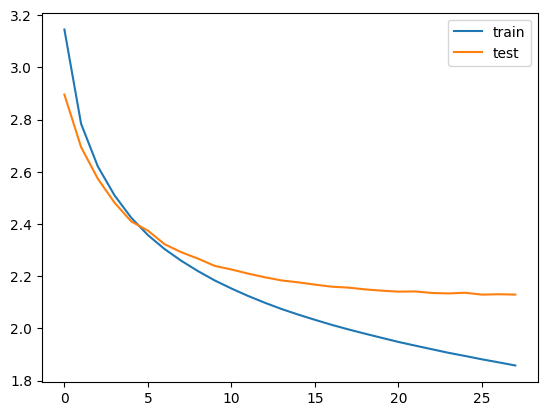

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Next, let’s build the dictionary to convert the index to word for target and source vocabulary:

In [41]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

## Inference

Set up the inference for the encoder and decoder:

In [42]:
import tensorflow as tf
from attention import AttentionLayer
model=tf.keras.models.load_model("./weights.28-2.13.hdf5", custom_objects={"AttentionLayer": AttentionLayer}) # Complete the code

2024-04-22 14:24:08.655127: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-22 14:24:08.735714: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-22 14:24:08.737589: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-22 14:24:08.739843: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F AVX512_VNNI
To enable them in other operations, rebu

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [43]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 80, 100)      2746000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 80, 300),    481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [44]:
# Access the variables/layers directly from the loaded model
encoder_inputs = model.get_layer('input_1').output
encoder_outputs = model.get_layer('lstm_2').output[0]  # Access the first output which is the output of the last LSTM layer in the encoder
state_h = model.get_layer('lstm_2').output[1]  # Access the hidden state
state_c = model.get_layer('lstm_2').output[2]  # Access the cell state

decoder_inputs = model.get_layer('input_2').output
dec_emb_layer = model.get_layer('embedding_1')
decoder_lstm = model.get_layer('lstm_3')
attn_layer = model.get_layer('attention_layer')
decoder_dense = model.get_layer('time_distributed')

In [46]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

We are defining a function below which is the implementation of the inference process

In [47]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

In [48]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

Here are a few summaries generated by the model:

In [68]:
for i in range(0, 5):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: happy gluten free puffs thought kiddo would miss finger food together allergies loves 
Original summary: thrilled it is gluten free 
1/1 [==============================] - 0s 25ms/step
Predicted summary:  great gluten free snack


Review: like goji berries purchased products navitas naturals good quality received immediately opened tried smelled tasted slightly moldy see mold opened second package tasted put away disregarded taste started feel little sick went back packages cut perfectly fine looking berries open filled mold definitely purchasing product matter packed nutrients made temporarily paranoid dried stuff eat looks fine outside shame returns item noticing reviews mold problem fairly common 
Original summary: mold 
1/1 [==============================] - 0s 24ms/step
Predicted summary:  mold mold


Review: kids thought much like pasta tomato soup crazy 
Original summary: just okay 
1/1 [==============================] - 0s 24ms/step
Predicted summary:  kids love it


Re

In [49]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [50]:
from nltk.translate.bleu_score import corpus_bleu

In [51]:
evaluation_number = 500

In [52]:
%%capture
tokenized_references = [[nltk.word_tokenize(seq2summary(refs))] for refs in y_val[:evaluation_number]]

In [53]:
%%capture
tokenized_candidates = [nltk.word_tokenize(decode_sequence(text.reshape(1,max_text_len))) for text in x_val[:evaluation_number]]

In [54]:
try:
    from nltk.translate.bleu_score import corpus_bleu
    bleu_score = corpus_bleu(tokenized_references, tokenized_candidates)
    print(bleu_score)
except:
    print("ERROR")
    from nltk.translate.bleu_score import SmoothingFunction
    bleu_score = corpus_bleu(tokenized_references, tokenized_candidates, smoothing_function=SmoothingFunction().method1)
    print(bleu_score)

7.025008283553595e-79


In [55]:
actual_summary = [x[0] for x in tokenized_references]

In [63]:
original_text = [nltk.word_tokenize(seq2text(x)) for x in x_val[:evaluation_number]]

In [94]:
import spacy
from sklearn.metrics.pairwise import cosine_similarity
# Load the English model for spaCy
nlp = spacy.load('en_core_web_md')  # Load the spaCy model for English language

# Define a function to compare cosine similarity between two texts
def compare_cosine_similarity(text1, text2, debug=False):
    # Process the texts using spaCy to tokenize and assign word vectors
    doc1 = nlp(text1)  # Tokenization and word vectorization for text1
    doc2 = nlp(text2)  # Tokenization and word vectorization for text2
    
    if debug:
        # print(len(text1.split())) # 41
        # print(type(doc1))
        # print(doc1)
        # print([token.vector for token in doc1 if token.has_vector])
        # print(len([token.vector for token in doc1 if token.has_vector])) # 41
        # print(len([token.vector for token in doc1 if token.has_vector][0])) # 300
        pass
    
    # Calculate the average word vectors for each document
    vec1 = np.mean([token.vector for token in doc1 if token.has_vector], axis=0)  # Vector averaging for text1 (each embedding has 300 values)
    vec2 = np.mean([token.vector for token in doc2 if token.has_vector], axis=0)  # Vector averaging for text2 (each embedding has 300 values)
    
    # if debug:
    #     print(vec1)
    
    # Calculate the cosine similarity between the vectors
    similarity_score = cosine_similarity([vec1], [vec2])[0][0]  # Cosine similarity calculation between vec1 and vec2
    return similarity_score  # Return the cosine similarity score

In [95]:
similarity = []  # Initialize a list to store similarity scores
similarity_summary = []

for i in range(evaluation_number):
    if i%100 == 0:
        print(f'progress: {(i*100)/evaluation_number}%')  # tracking progress
    debug = False if i > 0 else True
    similarity.append(compare_cosine_similarity(' '.join(original_text[i]), ' '.join(tokenized_candidates[i]), debug))  # Compute and store the cosine similarity between the original text and its summary
    similarity_summary.append(compare_cosine_similarity(' '.join(actual_summary[i]), ' '.join(tokenized_candidates[i])))


progress: 0.0%
300
progress: 20.0%
progress: 40.0%
progress: 60.0%
progress: 80.0%


In [76]:
# Calculate the average similarity score
average1 = sum(similarity) / len(similarity)  
average2 = sum(similarity_summary) / len(similarity_summary)  

print(f'The cosine simmilarity with the text is {average1}')
print(f'The cosine simmilarity with the summary is {average2}')

The cosine simmilarity with the text is 0.6266710266217124
The cosine simmilarity with the summary is 0.5038295055746567


Finally, Our model is able to generate a meaningful summary based on the context present in the text.

## Text Summarization using Transformers

In [54]:
from transformers import pipeline

Summarize news articles and other documents.
This summarizing pipeline can currently be loaded from pipeline() using the following task identifier: "summarization".
The models that this pipeline can use are models that have been fine-tuned on a summarization task, which is currently, ‘bart-large-cnn’, ‘t5-small’, ‘t5-base’, ‘t5-large’, ‘t5-3b’, ‘t5-11b’.

https://huggingface.co/t5-base

https://huggingface.co/models?filter=summarization

In [55]:
import bs4 as bs
import urllib.request
import re

In [56]:
scraped_data = urllib.request.urlopen('https://en.wikipedia.org/wiki/Artificial_intelligence')
article = scraped_data.read()
parsed_article = bs.BeautifulSoup(article,'lxml')
paragraphs = parsed_article.find_all('p')

KeyboardInterrupt: 

In [ ]:
article_text = ""
for p in paragraphs:
    article_text += p.text

In [ ]:
article_text[0:500]

In [ ]:
# Text preprocessing

# Removing Square Brackets and Extra Spaces
article_text = re.sub(r'\[[0-9]*\]', ' ', article_text)
article_text = re.sub(r'\s+', ' ', article_text)

In [ ]:
# Removing special characters and digits
formatted_article_text = re.sub('[^a-zA-Z]', ' ', article_text )
formatted_article_text = re.sub(r'\s+', ' ', formatted_article_text)

In [ ]:
len(formatted_article_text)

In [ ]:
formatted_article_text_1=formatted_article_text[0:500]

In [ ]:
#use t5 in tf
summarizer1 = pipeline("summarization", model="t5-base", tokenizer="t5-base", framework="tf")

In [ ]:
formatted_article_text_1

In [ ]:
summarizer1(formatted_article_text_1, min_length=5, max_length=500,do_sample=False)

In [ ]:
summarizer1(formatted_article_text_1, min_length=5, max_length=20,do_sample=False)

In [ ]:
text_string=data.Text[0]
text_string

In [ ]:
summarizer1(text_string, min_length=5, max_length=20,do_sample=False)